_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, plot_roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [3]:
'''T1. Import data file.'''
#Attach HTML to url variable
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'

#Read in df, parse/index Inspection Date col.
df = pd.read_csv(url, parse_dates= ['Inspection Date'], index_col= 'Inspection Date')

#View change
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0


**Task 1 Test**

In [4]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [5]:
'''T2. Identify data leakage column.'''
# Identiy Leak Target
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [6]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [7]:
'''T3. Write wrangle function.'''
def wrangle(df):
  #Create cutoff for HCCC
  #Create list of col to drop using for loop and if statement
  #Drop HCCC cols
  cutoff = 500
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  #Drop all columns that have no importance to our Target
  df.drop(columns = ['State', leaky_col, 'City', 'Zip'], inplace = True)

  #Data cleaning for col
  #df.columns = (df.columns
                #.str.replace(' ', '_')
                #.str.lower())

  return df
# Wrangle df
df = wrangle(df)

In [8]:
df.head()

,Inspection ID,License #,Facility Type,Risk,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2017-09-15,2088270,2354911.0,Restaurant,Risk 1 (High),Canvass,41.938007,-87.644755,1
2011-10-20,555268,1044901.0,Grocery Store,Risk 3 (Low),Complaint Re-Inspection,41.772402,-87.683603,0
2016-04-05,1751394,47405.0,Restaurant,Risk 1 (High),Canvass Re-Inspection,41.758779,-87.575054,0
2016-04-29,1763905,6414.0,Restaurant,Risk 2 (Medium),Canvass,41.812181,-87.707125,0
2011-01-10,453326,24571.0,School,Risk 1 (High),Canvass,NaN,NaN,0


**Task 3 Test**

In [9]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [10]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# Our wrangled DF already has target vector dropped and is cleaned as we want it to be
X = df.drop(columns = target)

# Use copy of df to attach target to y
y = df[target]

**Task 4 Test**

In [11]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [12]:
'''T5. Split dataset into training and validation sets.'''
# Create cutoff for DTO
cutoff = '2017'

#Create mask using cutoff
mask = X.index < cutoff

#Create Training/Validation split
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

**Task 5 Testing**

In [13]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [14]:
'''T6. Establish baseline accuracy.'''
# Create baseline accuracy
baseline_acc = y_train.value_counts(normalize=True).max()

#Multiply by 100 to show as percentage
print('Baseline accuracy:', baseline_acc * 100)

Baseline accuracy: 75.06634470557294


**Task 6 Testing**

In [15]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [16]:
'''T7. Build model with bagging predictor.'''
# Instantiate Model with Pipeline
model_bag = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=50, max_depth = 15)
)
#Fit the model
model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [17]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [18]:
'''T8. Build model with boosting predictor.'''
#Instantiate Model with Pipeline
model_boost = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    XGBClassifier(random_state= 42)
)
#Fit the model
model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [19]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

Based off our Validation Accuracy, the Boosting Model performed slightly better than our Bagging Model before any HyperParameter Tuning

In [20]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.7726827169053482
Validation accuracy: 0.7025473287739121

Boosting Model
Training accuracy: 0.7638367561622875
Validation accuracy: 0.7031420358806622


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

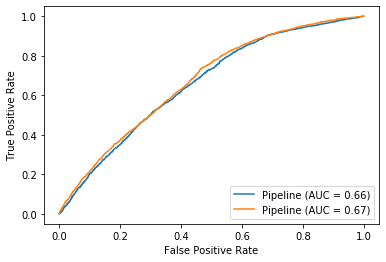

In [21]:
'''T9. Plot ROC-curve.'''
# Plot ROC Curves side-by-side
rf = plot_roc_curve(model_bag, X_val, y_val)
xgb = plot_roc_curve(model_boost, X_val, y_val, ax = rf.ax_)

In [22]:
y_val.shape

(10089,)

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [23]:
'''T10. Generate classification report for one model.'''
# Create Classification Report
from sklearn.metrics import classification_report
model_cr = classification_report(y_val, model_boost.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.70      1.00      0.83      7092
           1       0.67      0.00      0.00      2997

    accuracy                           0.70     10089
   macro avg       0.68      0.50      0.41     10089
weighted avg       0.69      0.70      0.58     10089



**Task 10 Testing**

In [24]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [25]:
'''T11. Create DataFrame of permutation importances.'''
# Create the permutations based off model_boost
permutation = permutation_importance(model_boost, X_val, y_val, random_state=42)

# Creaete two columns, one with mean, one with standard dev
data = {'importance_mean' : permutation['importances_mean'],
        'importance_std' : permutation['importances_std']}


permutation_importances = pd.DataFrame(data, index = X_val.columns).sort_values(by='importance_mean')

**Task 11 Testing**

In [26]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f769cb80650>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f769cbed450>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


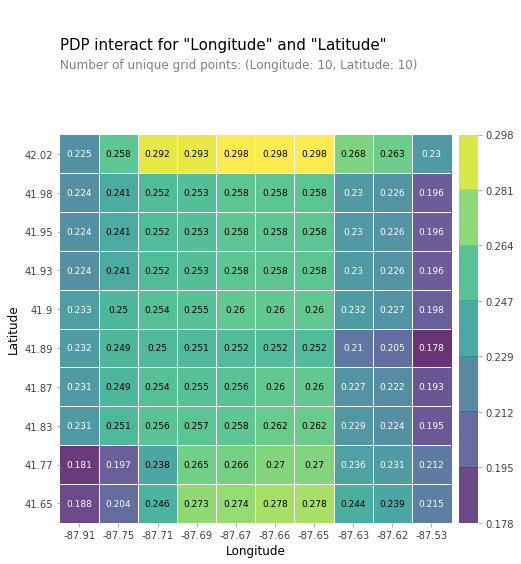

In [27]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
features = ['Longitude', 'Latitude']
interact = pdp_interact(model_boost,
                        dataset = X_val.dropna(),
                        model_features = X_val.columns,
                        features = features)

pdp_interact_plot(interact,plot_type = 'grid', feature_names = features)

What do you think? Is there a relationship between location and failing a food saftey inspection?

With no domain knowledge, I would say that, based on the data, there is very little corrolation between location and failing a safety inspection.